In [1]:
import torch
import yolov5
import torch.nn as nn
import cv2
from torchvision import transforms
from PIL import Image
import joblib
import sklearn
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import random
import numpy as np

### Någonting som behövdes med den nya modellen, fråga inte varför bara gör.

In [2]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

## YOLOv5 hitta och croppa ut fisk modell:

### Om man har kört pip install på yolov5 så fungerar det att importera modellen på följande sätt

In [27]:
model_path = "./saved_models/fish_model_volov5_29-01-24.pt"
fish_model = yolov5.load(model_path)
fish_model.conf = 0.30

YOLOv5  2024-1-19 Python-3.10.11 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 291 layers, 20871318 parameters, 0 gradients, 48.2 GFLOPs
Adding AutoShape... 


### Om man istället har yolov5 liggandes någonstans på datorn så kan man hämta den på följande sätt

In [ ]:
# yolo_path = "C:/Users/emmel/Desktop/testning av yolov5/yolov5"
# model_path = "./saved_models/fish_model_yolov5_23-12-20.pt"

# fish_model = torch.hub.load(yolo_path, 'custom', path=model_path, source='local')
# fish_model.conf = 0.10

## Sjuk fisk CNN modell
### Exempelkod för att ladda den modell vi väl använder:

In [4]:
#sick_model = joblib.load("./saved_models/my_random_forest.joblib")
loaded_model = load_model('./saved_models/cnn_model_cropped_more_healthy_30-1-24.h5')

### Testbild

In [5]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

### Tar fram en slumvis bild ur en mapp som man får lägga till pathen till

In [52]:
folder_path = './dataset/test_img/Healthy_fishies/Sea Bass/'
test_image_path = random_image(folder_path)
original_image = cv2.imread(test_image_path)
image = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

### Vi börjar med att visa upp originalbilden

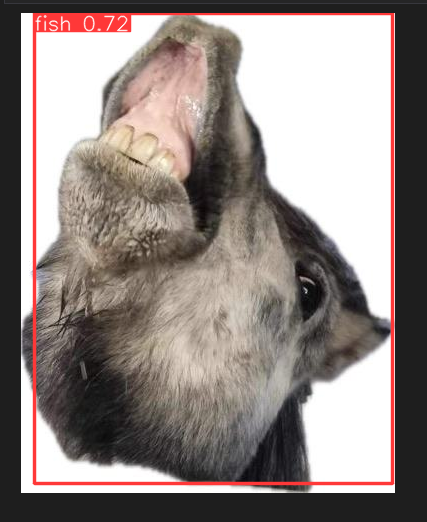

In [53]:
display(image)

### Vi tar fram enbart vad YOLO modellen tar fram för koordinater för fisken, om det faktiskt finns en fisk

In [54]:
yolo_result = fish_model(image)
yolo_preds = yolo_result.pandas().xyxy[0]

In [55]:
predictions = yolo_result.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

### Vi ritar ut originalbilden tillsammans med YOLOs predict

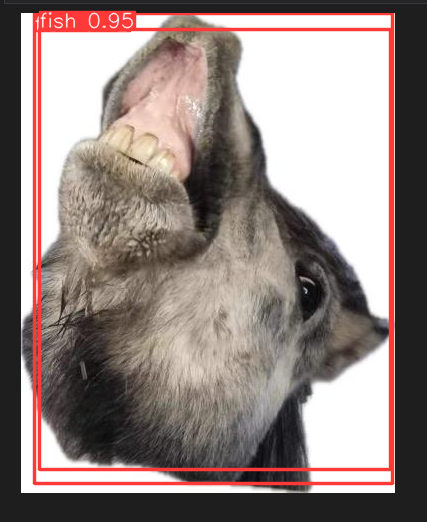

In [56]:
yolo_result.show()

### En funktion för förbehandling av bilden för CNN modellen

In [26]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

### Vi börjar med att testa vad originalbilden får för predict utan att ha gått igenom YOLO modellen och blivit croppad

In [27]:
test_image = prepare_images([test_image_path])

# Gör prediktion med modellen
prediction = loaded_model.predict(test_image)

# Bestäm förutsagd klass och spara i listor
predicted_class_index = np.argmax(prediction[0])
class_labels = ["Diseased", "Healthy"]
predicted_class_label = class_labels[predicted_class_index]
confidence_score = prediction[0][predicted_class_index]

print(predicted_class_label, confidence_score)

1/1 [==============================] - 0s 119ms/step
Diseased 1.0


### Nu testar vi hela ledet, vi skickar bilden till YOLO som ser om det finns en eller flera fiskar på bilden och isåfall sätter en ruta runt dom och skickar ut koordinater, dessa tar vi och croppar ut fisken och testar det i CNN modelle, detta eftersom att få bort så mycket bakgrund som möjligt för att hjälpa CNN modellen.

        xmin       ymin        xmax        ymax  confidence  class  name
0  89.866295  17.701775  580.985413  433.792236    0.949912      0  fish
Fish detected
89 17 580 433


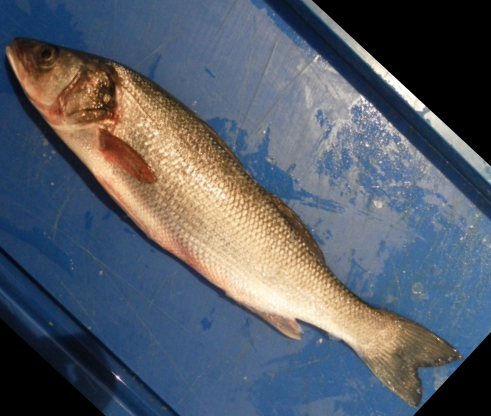

1/1 [==============================] - 0s 18ms/step
Diseased 1.0


In [66]:
yolo_result = fish_model(image)
yolo_preds = yolo_result.pandas().xyxy[0]

print(yolo_preds)

if len(yolo_preds) > 0:
    print(f"Fish detected")
    
    for _, yolo_pred in yolo_preds.iterrows():
        bbox = yolo_pred[['xmin', 'ymin', 'xmax', 'ymax']].astype(int).tolist()
        # roi = original_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        print(bbox[0],bbox[1], bbox[2],bbox[3])
        crop_coordinates = (bbox[0],bbox[1],bbox[2],bbox[3])
        cropped_image = image.crop(crop_coordinates)

        cropped_image.save('test.jpg')

        display(cropped_image)

        cropped_image_array = img_to_array(cropped_image)
        cropped_image_array = tf.image.resize(cropped_image_array, (64, 64))
        cropped_image_array = np.expand_dims(cropped_image_array, axis=0)

        # Gör prediktion med modellen
        prediction = loaded_model.predict(cropped_image_array)

        predicted_class_index = np.argmax(prediction[0])
        class_labels = ["Diseased", "Healthy"]
        predicted_class_label = class_labels[predicted_class_index]
        confidence_score = prediction[0][predicted_class_index]

        print(predicted_class_label, confidence_score)

        # Preprocessing för sick model  

        # second_model_output = sick_model.predict([........])

        # print(f"Prediction for ROI: Class {second_model_output[0]}")

else:
    print(f"No fish detected")
